In [1]:
# Transformer based classifier, we will start with metadata only
import torch.nn as nn
import torch
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset,MultiViewMetaDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test
import pandas as pd
import random

In [2]:
def set_random_seeds(seed):
    random.seed(seed)          # Python random module
    np.random.seed(seed)       # NumPy random module
    torch.manual_seed(seed)    # PyTorch CPU random generator
    torch.cuda.manual_seed(seed)  # PyTorch GPU random generator (if using CUDA)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior on CUDA
    torch.backends.cudnn.benchmark = False    # Avoid non-deterministic algorithms

In [3]:
set_random_seeds(42)
# Model parameters.
EMBED_DIM = 512
NUM_ENCODER_LAYERS = 4
NUM_HEADS = 8

# Constants:
DATASET = 'C:\\Users\\preet\\Documents\\mBRSET\\mbrset-a-mobile-brazilian-retinal-dataset-1.0\\'
DOWNLOAD = False
#SHAPE = (224, 224)
SHAPE = (512, 512)
IMAGES = os.path.join(DATASET, 'images')
LABEL = 'final_icdr'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'multi_labels.csv')
IMG_COL_LIST=['file1','file2','file3','file4']
metadata_features= ['sex', 'insulin','oraltreatment_dm','systemic_hypertension','alcohol_consumption','smoking','obesity',
                  'vascular_disease', 'acute_myocardial_infarction','nephropathy','neuropathy', 'diabetic_foot','age_index','dm_index']
NUM_METADATA_FEATURES = len(metadata_features)

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
"""
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]


#NORM_MEAN = None # [0.485, 0.456, 0.406]
#NORM_STD = None # [0.229, 0.224, 0.225]
BACKBONE = 'resnet50'
BATCH_SIZE = 64 #16
#BACKBONE = 'dinov2_large'
#BATCH_SIZE = 4 #16
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128, 128]
num_classes = 2

NUM_WORKERS = 8 #4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 100
learning_rate = 1e-4
#LR=1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [4]:
df = pd.read_csv(LABELS_PATH)

print(df.shape)
df.head(5)

(1291, 29)


,Unnamed: 0,patient,age,sex,dm_time,insulin,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,laterality,final_artifacts,final_quality,final_icdr,final_edema,file2,file3,file4,age_index,dm_index
0,0,1,58,1,15.0,1.0,1.0,1.0,0.0,3.0,...,right,yes,yes,1,no,1.2.jpg,1.3.jpg,1.4.jpg,4,2
1,4,10,63,0,7.0,0.0,1.0,1.0,0.0,2.0,...,right,yes,yes,0,no,10.2.jpg,10.3.jpg,10.4.jpg,5,1
2,8,100,66,1,1.0,0.0,1.0,0.0,0.0,1.0,...,right,yes,yes,0,no,100.2.jpg,100.3.jpg,100.4.jpg,5,0
3,12,1000,50,0,2.0,0.0,1.0,0.0,0.0,5.0,...,right,yes,yes,0,no,1000.2.jpg,1000.3.jpg,1000.4.jpg,4,0
4,16,1001,36,0,2.0,0.0,1.0,0.0,0.0,5.0,...,right,yes,yes,0,no,1001.2.jpg,1001.3.jpg,1001.4.jpg,2,0


In [5]:
# File to split datasets based on patients and also do stratified sampling
# Split dataset into train, test and validation:
# Count NaNs in each column
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0.0 else ('DR'))
# Separate out patients for training and test

nan_counts = df.isna().sum()
#print(df.shape)
#print(nan_counts)

#for feat in ['age', 'sex','dm_time','insulin', 'oraltreatment_dm','systemic_hypertension','educational_level','alcohol_consumption','smoking','obesity',
#            'vascular_disease', 'acute_myocardial_infarction','nephropathy','neuropathy', 'diabetic_foot']:                 
#    plt.hist(df[feat])
#    plt.title(feat)
#    plt.show()
#df.drop(columns=['insulin_time'],inplace=True)
#df.fillna(0,inplace=True)
nan_counts = df.isna().sum()
print(df.shape)
#print(nan_counts)

(1291, 29)


(1291, 29)
Unnamed: 0                     0
patient                        0
age                            0
sex                            0
dm_time                        0
insulin                        0
oraltreatment_dm               0
systemic_hypertension          0
insurance                      0
educational_level              0
alcohol_consumption            0
smoking                        0
obesity                        0
vascular_disease               0
acute_myocardial_infarction    0
nephropathy                    0
neuropathy                     0
diabetic_foot                  0
file1                          0
laterality                     0
final_artifacts                0
final_quality                  0
final_icdr                     0
final_edema                    0
file2                          0
file3                          0
file4                          0
age_index                      0
dm_index                       0
dtype: int64
Train data shape: (

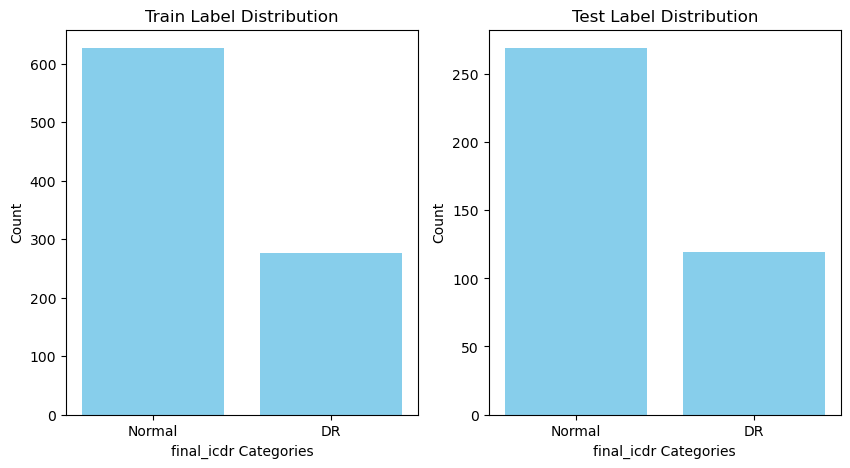

Getting validation set...
Train data shape: (310, 29)
Test data shape: (78, 29)


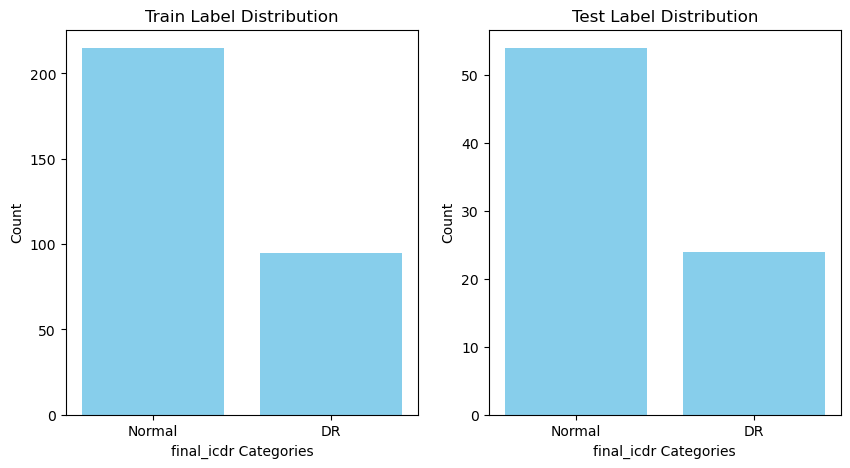

In [6]:
# Split dataset into train, test and validation:
# Count NaNs in each column

nan_counts = df.isna().sum()
print(df.shape)
print(nan_counts)
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False,random_state=42)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20,random_state=42)

In [7]:
print(df_train.head())
print(LABEL)
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

      Unnamed: 0  patient  age  sex  dm_time  insulin  oraltreatment_dm   
90           360     1086   78    1      2.0      1.0               1.0  \
70           280     1066   57    1      1.0      0.0               1.0   
490         1960      260   69    0     22.0      1.0               0.0   
81           324     1077   59    0      5.0      0.0               1.0   
1256        5024      966   66    0      5.0      0.0               1.0   

      systemic_hypertension  insurance  educational_level  ...  laterality   
90                      1.0        0.0                1.0  ...       right  \
70                      1.0        0.0                3.0  ...       right   
490                     1.0        0.0                2.0  ...       right   
81                      1.0        0.0                1.0  ...       right   
1256                    0.0        0.0                5.0  ...       right   

      final_artifacts  final_quality  final_icdr  final_edema       file2   
90 

In [8]:

# Define the target image shape

train_transforms = transforms.Compose([
#    transforms.Resize((256, 256)),
    transforms.Resize((640, 640)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])



if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [9]:
# Create the custom dataset
torch.multiprocessing.set_sharing_strategy('file_system')

META_COL_LIST = metadata_features #['sex','smoking','obesity']
train_dataset = MultiViewMetaDataset(
    df_train, 
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms,
    meta_only=False
)

test_dataset = MultiViewMetaDataset(
    df_test, 
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform,
    meta_only=False
)

val_dataset = MultiViewMetaDataset(
    df_val, 
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform,
    meta_only=False
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

torch.Size([903, 14])
['file1', 'file2', 'file3', 'file4']
[array(['1086.1.jpg', '1066.1.jpg', '260.1.jpg', '1077.1.jpg', '966.1.jpg',
       '1217.1.jpg', '1257.1.jpg', '1147.1.jpg', '262.1.jpg', '828.1.jpg',
       '1105.1.jpg', '1153.1.jpg', '627.1.jpg', '772.1.jpg', '144.1.jpg',
       '372.1.jpg', '409.1.jpg', '906.1.jpg', '1312.1.jpg', '1240.1.jpg',
       '885.1.jpg', '650.1.jpg', '299.1.jpg', '1048.1.jpg', '80.1.jpg',
       '1262.1.jpg', '288.1.jpg', '750.1.jpg', '1310.1.jpg', '125.1.jpg',
       '160.1.jpg', '357.1.jpg', '17.1.jpg', '418.1.jpg', '209.1.jpg',
       '1155.1.jpg', '1311.1.jpg', '643.1.jpg', '1089.1.jpg', '533.1.jpg',
       '224.1.jpg', '1223.1.jpg', '1305.1.jpg', '929.1.jpg', '606.1.jpg',
       '890.1.jpg', '1127.1.jpg', '48.1.jpg', '968.1.jpg', '1037.1.jpg',
       '1004.1.jpg', '1300.1.jpg', '515.1.jpg', '178.1.jpg', '369.1.jpg',
       '13.1.jpg', '1227.1.jpg', '382.1.jpg', '581.1.jpg', '1080.1.jpg',
       '1293.1.jpg', '486.1.jpg', '575.1.jpg', '435.1.jp

In [10]:
# Basic model, note that it has no positional encoding.
class EncoderClassifier(nn.Module):
    def __init__(self, backbone,num_metadata_features, embed_dim, num_layers, num_heads):
        super(EncoderClassifier, self).__init__()
        self.backbone = backbone
        self.emb =[]
        self.num_metadata_features = num_metadata_features # change to num_metadata_features
        for i in range(num_metadata_features):
            self.emb.append(nn.Embedding(8, embed_dim))
        print(len(self.emb))
        print(self.emb[0].weight.size())

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=self.encoder_layer,
            num_layers=num_layers,
        )
        self.linear = nn.Linear(embed_dim, 2)
        
        self.dropout = nn.Dropout(0.2)
        # For DinoV2
        #self.backboneLinear = nn.Linear(1024,embed_dim)
        # For resnet
        self.backboneLinear = nn.Linear(2048,embed_dim)
    def forward(self, x_list=None, x_meta=None):
        
        y = [None] * self.num_metadata_features
        for i in range(self.num_metadata_features):
            y[i] = self.emb[i](x_meta[:,i])

        x = torch.stack(y,dim=1)
        #print(x.size())
        #print(x.size(), avg_features[0].size(), avg_features[1].size())
        B = x.size()[0]
      #  x = torch.cat((x), dim=1)        
#        x = torch.cat((self.cls_emb.repeat(B,1,1),x), dim=1)        
        x = self.encoder(x) #Transformer Encoder
        #print("after transform", x.size())
        x = self.dropout(x)
        x = x.mean(dim=1)
        #print("after max", x.size())
        #print(x.size(), x_img.size())
        #x_final = torch.concat((x_img,x),dim=1)
        #print('Out shape',x_final.size())
        out = self.linear(x)
        return out   

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)

model = EncoderClassifier(
    backbone = backbone_model,
    num_metadata_features =NUM_METADATA_FEATURES,
    embed_dim=EMBED_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    num_heads=NUM_HEADS
)
model.to(device)
for idx in range(len(model.emb)):
    model.emb[idx].to(device)
#print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

14
torch.Size([8, 512])
40,320,066 total parameters.
40,320,066 training parameters.



In [12]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [13]:
save_dir= 'C:\\Users\\preet\\Documents\\mBRSET\\mBRSET\\MetaResnetModels'
model = train(model, train_dataloader, val_dataloader,test_dataloader,
              criterion, optimizer, scheduler=None, num_epochs=num_epochs, save=True, save_dir = save_dir,device="cuda", 
              backbone=f'convnextv2_binary_{LABEL}')

AMP True


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:34<00:00, 10.28s/it]


Epoch 1
Train loss 0.864, F1 0.489, Acc 0.516, BA 0.503
cm[[130 146]
 [291 336]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.31s/it]


Epoch 1
Val loss 0.767, F1 0.235, Acc 0.308, BA 0.500
cm[[24  0]
 [54  0]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.43s/it]


cm[[ 95   0]
 [215   0]]
              precision    recall  f1-score   support

           0       0.31      1.00      0.47        95
           1       0.00      0.00      0.00       215

    accuracy                           0.31       310
   macro avg       0.15      0.50      0.23       310
weighted avg       0.09      0.31      0.14       310

F1 0.144, Acc 0.306, BA 0.500
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:18<00:00,  9.23s/it]


Epoch 2
Train loss 0.675, F1 0.573, Acc 0.594, BA 0.600
cm[[170 106]
 [261 366]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.23s/it]


Epoch 2
Val loss 0.640, F1 0.385, Acc 0.397, BA 0.530
cm[[21  3]
 [44 10]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.55s/it]


cm[[ 87   8]
 [155  60]]
              precision    recall  f1-score   support

           0       0.36      0.92      0.52        95
           1       0.88      0.28      0.42       215

    accuracy                           0.47       310
   macro avg       0.62      0.60      0.47       310
weighted avg       0.72      0.47      0.45       310

F1 0.452, Acc 0.474, BA 0.597
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:15<00:00,  9.03s/it]


Epoch 3
Train loss 0.652, F1 0.623, Acc 0.647, BA 0.646
cm[[178  98]
 [221 406]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.03s/it]


Epoch 3
Val loss 0.591, F1 0.548, Acc 0.551, BA 0.606
cm[[18  6]
 [29 25]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.83s/it]


cm[[ 80  15]
 [102 113]]
              precision    recall  f1-score   support

           0       0.44      0.84      0.58        95
           1       0.88      0.53      0.66       215

    accuracy                           0.62       310
   macro avg       0.66      0.68      0.62       310
weighted avg       0.75      0.62      0.63       310

F1 0.634, Acc 0.623, BA 0.684
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:18<00:00,  9.22s/it]


Epoch 4
Train loss 0.613, F1 0.664, Acc 0.707, BA 0.670
cm[[159 117]
 [148 479]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.75s/it]


Epoch 4
Val loss 0.632, F1 0.444, Acc 0.449, BA 0.567
cm[[21  3]
 [40 14]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.67s/it]


cm[[ 83  12]
 [144  71]]
              precision    recall  f1-score   support

           0       0.37      0.87      0.52        95
           1       0.86      0.33      0.48       215

    accuracy                           0.50       310
   macro avg       0.61      0.60      0.50       310
weighted avg       0.71      0.50      0.49       310

F1 0.488, Acc 0.497, BA 0.602


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:20<00:00,  9.39s/it]


Epoch 5
Train loss 0.644, F1 0.646, Acc 0.674, BA 0.665
cm[[177  99]
 [195 432]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:26<00:00, 13.33s/it]


Epoch 5
Val loss 0.610, F1 0.460, Acc 0.462, BA 0.565
cm[[20  4]
 [38 16]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.42s/it]


cm[[ 83  12]
 [124  91]]
              precision    recall  f1-score   support

           0       0.40      0.87      0.55        95
           1       0.88      0.42      0.57       215

    accuracy                           0.56       310
   macro avg       0.64      0.65      0.56       310
weighted avg       0.74      0.56      0.57       310

F1 0.565, Acc 0.561, BA 0.648


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:20<00:00,  9.33s/it]


Epoch 6
Train loss 0.591, F1 0.670, Acc 0.699, BA 0.688
cm[[182  94]
 [178 449]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.74s/it]


Epoch 6
Val loss 0.585, F1 0.589, Acc 0.654, BA 0.588
cm[[10 14]
 [13 41]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.18s/it]


cm[[ 55  40]
 [ 47 168]]
              precision    recall  f1-score   support

           0       0.54      0.58      0.56        95
           1       0.81      0.78      0.79       215

    accuracy                           0.72       310
   macro avg       0.67      0.68      0.68       310
weighted avg       0.73      0.72      0.72       310

F1 0.722, Acc 0.719, BA 0.680
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:22<00:00,  9.48s/it]


Epoch 7
Train loss 0.595, F1 0.676, Acc 0.704, BA 0.695
cm[[185  91]
 [176 451]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:26<00:00, 13.15s/it]


Epoch 7
Val loss 0.556, F1 0.641, Acc 0.705, BA 0.637
cm[[11 13]
 [10 44]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.30s/it]


cm[[ 57  38]
 [ 43 172]]
              precision    recall  f1-score   support

           0       0.57      0.60      0.58        95
           1       0.82      0.80      0.81       215

    accuracy                           0.74       310
   macro avg       0.69      0.70      0.70       310
weighted avg       0.74      0.74      0.74       310

F1 0.741, Acc 0.739, BA 0.700
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:23<00:00,  9.58s/it]


Epoch 8
Train loss 0.607, F1 0.673, Acc 0.704, BA 0.688
cm[[178  98]
 [169 458]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.62s/it]


Epoch 8
Val loss 0.560, F1 0.650, Acc 0.705, BA 0.648
cm[[12 12]
 [11 43]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.60s/it]


cm[[ 53  42]
 [ 45 170]]
              precision    recall  f1-score   support

           0       0.54      0.56      0.55        95
           1       0.80      0.79      0.80       215

    accuracy                           0.72       310
   macro avg       0.67      0.67      0.67       310
weighted avg       0.72      0.72      0.72       310

F1 0.721, Acc 0.719, BA 0.674
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:24<00:00,  9.64s/it]


Epoch 9
Train loss 0.584, F1 0.680, Acc 0.709, BA 0.697
cm[[184  92]
 [171 456]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:26<00:00, 13.40s/it]


Epoch 9
Val loss 0.568, F1 0.609, Acc 0.692, BA 0.604
cm[[ 9 15]
 [ 9 45]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.22s/it]


cm[[ 46  49]
 [ 39 176]]
              precision    recall  f1-score   support

           0       0.54      0.48      0.51        95
           1       0.78      0.82      0.80       215

    accuracy                           0.72       310
   macro avg       0.66      0.65      0.66       310
weighted avg       0.71      0.72      0.71       310

F1 0.711, Acc 0.716, BA 0.651


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:22<00:00,  9.47s/it]


Epoch 10
Train loss 0.642, F1 0.669, Acc 0.712, BA 0.673
cm[[158 118]
 [142 485]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.01s/it]


Epoch 10
Val loss 0.582, F1 0.609, Acc 0.692, BA 0.604
cm[[ 9 15]
 [ 9 45]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.10s/it]


cm[[ 44  51]
 [ 33 182]]
              precision    recall  f1-score   support

           0       0.57      0.46      0.51        95
           1       0.78      0.85      0.81       215

    accuracy                           0.73       310
   macro avg       0.68      0.65      0.66       310
weighted avg       0.72      0.73      0.72       310

F1 0.720, Acc 0.729, BA 0.655


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:37<00:00, 10.50s/it]


Epoch 11
Train loss 0.579, F1 0.687, Acc 0.720, BA 0.699
cm[[178  98]
 [155 472]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:31<00:00, 15.57s/it]


Epoch 11
Val loss 0.565, F1 0.653, Acc 0.731, BA 0.644
cm[[10 14]
 [ 7 47]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 14.00s/it]


cm[[ 48  47]
 [ 31 184]]
              precision    recall  f1-score   support

           0       0.61      0.51      0.55        95
           1       0.80      0.86      0.83       215

    accuracy                           0.75       310
   macro avg       0.70      0.68      0.69       310
weighted avg       0.74      0.75      0.74       310

F1 0.741, Acc 0.748, BA 0.681
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:31<00:00, 10.09s/it]


Epoch 12
Train loss 0.582, F1 0.701, Acc 0.735, BA 0.712
cm[[180  96]
 [143 484]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:30<00:00, 15.21s/it]


Epoch 12
Val loss 0.543, F1 0.631, Acc 0.705, BA 0.625
cm[[10 14]
 [ 9 45]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.93s/it]


cm[[ 50  45]
 [ 35 180]]
              precision    recall  f1-score   support

           0       0.59      0.53      0.56        95
           1       0.80      0.84      0.82       215

    accuracy                           0.74       310
   macro avg       0.69      0.68      0.69       310
weighted avg       0.74      0.74      0.74       310

F1 0.738, Acc 0.742, BA 0.682


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:30<00:00, 10.06s/it]


Epoch 13
Train loss 0.566, F1 0.696, Acc 0.729, BA 0.707
cm[[180  96]
 [149 478]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.02s/it]


Epoch 13
Val loss 0.562, F1 0.619, Acc 0.679, BA 0.618
cm[[11 13]
 [12 42]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.05s/it]


cm[[ 57  38]
 [ 50 165]]
              precision    recall  f1-score   support

           0       0.53      0.60      0.56        95
           1       0.81      0.77      0.79       215

    accuracy                           0.72       310
   macro avg       0.67      0.68      0.68       310
weighted avg       0.73      0.72      0.72       310

F1 0.720, Acc 0.716, BA 0.684


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:25<00:00,  9.72s/it]


Epoch 14
Train loss 0.580, F1 0.703, Acc 0.732, BA 0.720
cm[[190  86]
 [156 471]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.82s/it]


Epoch 14
Val loss 0.553, F1 0.642, Acc 0.718, BA 0.634
cm[[10 14]
 [ 8 46]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.08s/it]


cm[[ 48  47]
 [ 39 176]]
              precision    recall  f1-score   support

           0       0.55      0.51      0.53        95
           1       0.79      0.82      0.80       215

    accuracy                           0.72       310
   macro avg       0.67      0.66      0.67       310
weighted avg       0.72      0.72      0.72       310

F1 0.719, Acc 0.723, BA 0.662


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:29<00:00,  9.94s/it]


Epoch 15
Train loss 0.575, F1 0.685, Acc 0.714, BA 0.701
cm[[184  92]
 [166 461]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:25<00:00, 12.67s/it]


Epoch 15
Val loss 0.582, F1 0.642, Acc 0.718, BA 0.634
cm[[10 14]
 [ 8 46]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.72s/it]


cm[[ 49  46]
 [ 36 179]]
              precision    recall  f1-score   support

           0       0.58      0.52      0.54        95
           1       0.80      0.83      0.81       215

    accuracy                           0.74       310
   macro avg       0.69      0.67      0.68       310
weighted avg       0.73      0.74      0.73       310

F1 0.731, Acc 0.735, BA 0.674


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:31<00:00, 10.12s/it]


Epoch 16
Train loss 0.566, F1 0.699, Acc 0.729, BA 0.714
cm[[187  89]
 [156 471]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:33<00:00, 16.92s/it]


Epoch 16
Val loss 0.593, F1 0.620, Acc 0.705, BA 0.613
cm[[ 9 15]
 [ 8 46]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:07<00:00, 13.42s/it]


cm[[ 45  50]
 [ 35 180]]
              precision    recall  f1-score   support

           0       0.56      0.47      0.51        95
           1       0.78      0.84      0.81       215

    accuracy                           0.73       310
   macro avg       0.67      0.66      0.66       310
weighted avg       0.72      0.73      0.72       310

F1 0.719, Acc 0.726, BA 0.655


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:29<00:00,  9.99s/it]


Epoch 17
Train loss 0.553, F1 0.715, Acc 0.749, BA 0.724
cm[[182  94]
 [133 494]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.52s/it]


Epoch 17
Val loss 0.657, F1 0.538, Acc 0.538, BA 0.620
cm[[20  4]
 [32 22]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.98s/it]


cm[[ 78  17]
 [114 101]]
              precision    recall  f1-score   support

           0       0.41      0.82      0.54        95
           1       0.86      0.47      0.61       215

    accuracy                           0.58       310
   macro avg       0.63      0.65      0.58       310
weighted avg       0.72      0.58      0.59       310

F1 0.587, Acc 0.577, BA 0.645


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:28<00:00,  9.92s/it]


Epoch 18
Train loss 0.566, F1 0.657, Acc 0.678, BA 0.687
cm[[196  80]
 [211 416]]


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.15s/it]


Epoch 18
Val loss 0.601, F1 0.567, Acc 0.590, BA 0.588
cm[[14 10]
 [22 32]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.17s/it]

cm[[ 69  26]
 [ 78 137]]
              precision    recall  f1-score   support

           0       0.47      0.73      0.57        95
           1       0.84      0.64      0.72       215

    accuracy                           0.66       310
   macro avg       0.65      0.68      0.65       310
weighted avg       0.73      0.66      0.68       310

F1 0.677, Acc 0.665, BA 0.682
Early stopping triggered.


In [14]:

state_dict = torch.load('C:\\Users\\preet\\Documents\\mBRSET\\mBRSET\\MetaResnetModels\\fine_tuned_resnet50_best.pth')
model.load_state_dict(state_dict, strict=False) 
y_pred, y_true = test(model, test_dataloader, saliency=False, device=device)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.83s/it]

cm[[ 48  47]
 [ 31 184]]
              precision    recall  f1-score   support

           0       0.61      0.51      0.55        95
           1       0.80      0.86      0.83       215

    accuracy                           0.75       310
   macro avg       0.70      0.68      0.69       310
weighted avg       0.74      0.75      0.74       310

F1 0.741, Acc 0.748, BA 0.681


In [15]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
z = train_dataset[2]
print(z['meta'])
z= next(iter(train_dataloader))  
print(z['meta'].size())
print(z['meta'])
#for batch in train_dataloader:
#    images, meta, labels = batch['image'], batch['meta'], batch['labels']
#    print(meta.size())
emb =[]
for i in range(len(META_COL_LIST)):
    emb.append(nn.Embedding(2, 7))

print(z['meta'][:,0])
y = [None] * len(META_COL_LIST)
for i in range(len(META_COL_LIST)):
    y[i] = emb[i](z['meta'][:,i])
#print(y)
r = torch.stack(y,dim=1)

print(r.size())


tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4])
torch.Size([64, 14])
tensor([[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 6, 2],
        [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 5, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 5, 5],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 5, 4],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2],
        [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 6, 2],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1],
        [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 5, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3],
        [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 5, 2],
        [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 4, 2],
        [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

IndexError: index out of range in self

In [ ]:
X = df_train[META_COL_LIST].to_numpy()
Y = df_train[LABEL].apply(lambda x: 0 if x == 'Normal' else 1).to_numpy()

X_test = df_test[META_COL_LIST].to_numpy()

Y_test = df_test[LABEL].apply(lambda x: 0 if x == 'Normal' else 1).to_numpy()


In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
clf = RandomForestClassifier(max_depth=8, random_state=0)
#clf = DecisionTreeClassifier(random_state=0)
clf.fit(X,Y)
Y_pred = clf.predict(X_test)
# Create the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

print(cm)

acc = accuracy_score(Y_test, Y_pred)
ba = balanced_accuracy_score(Y_test, Y_pred)
print("acc",acc)
print("BA",ba)

In [ ]:
x =torch.randn(32,12,256)
x1 = torch.randn(32,256)
x2 = torch.randn(32,256)
x1 = torch.reshape(x1, (32,1,256))
x2 = torch.reshape(x2, (32,1,256))
r = torch.cat((x,x1,x2), dim=1)
print(r.size())

In [ ]:
x = torch.randn(8,14,512) 
y= x.mean(dim=1) 

print(y.size())
